In [1]:
!pip install -q xgboost shap imbalanced-learn

<ipython-input-5-1f09aeb8863f>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["bmi"].fillna(df["bmi"].mean(), inplace=True)


Accuracy: 0.835
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       103
           1       0.82      0.85      0.83        97

    accuracy                           0.83       200
   macro avg       0.83      0.84      0.83       200
weighted avg       0.84      0.83      0.84       200



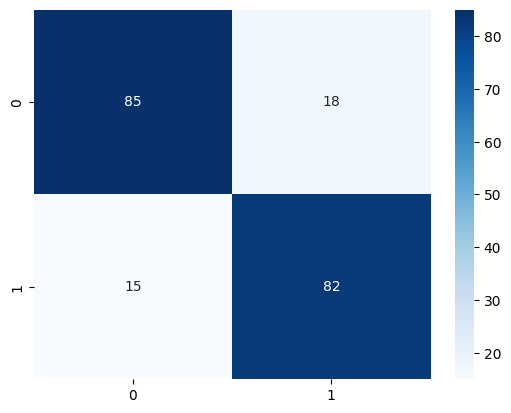


Importancia de las variables:


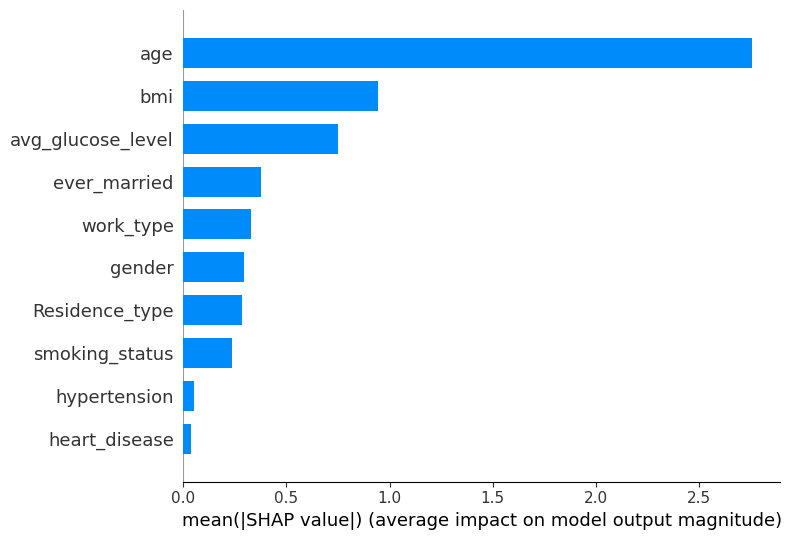

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import shap
import seaborn as sns
import matplotlib.pyplot as plt

# Cargamos el CSV
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop(columns=["id"], inplace=True)
df["bmi"].fillna(df["bmi"].mean(), inplace=True)
for col in ["gender","ever_married","work_type","Residence_type","smoking_status"]:
    df[col] = LabelEncoder().fit_transform(df[col])

# Definir variables predictoras y variable objetivo
X = df.drop(columns="stroke")
y = df["stroke"]

# Balanceo híbrido: undersample + SMOTE
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
sm = SMOTE(random_state=42)
X_bal, y_bal = sm.fit_resample(X_rus, y_rus)

# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# Entrenamiento XGBoost
model = XGBClassifier(n_estimators=100, random_state=42, eval_metric="logloss")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.show()

# SHAP para interpretabilidad
print("\nImportancia de las variables:")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")